# Demo with Lightning⚡Flash: Semantic Segmentation

**REF: https://lightning-flash.readthedocs.io/en/stable/reference/semantic_segmentation.html**

Semantic Segmentation, or image segmentation, is the task of performing classification at a pixel-level, meaning each pixel will associated to a given class. See more: https://paperswithcode.com/task/semantic-segmentation

Let’s look at an example using a data set generated with the CARLA driving simulator. The data was generated as part of the Kaggle Lyft Udacity Challenge. The data contains one folder of images and another folder with the corresponding segmentation masks.

Once we’ve connected the dataset, we create the `SemanticSegmentationData`. We select a pre-trained `mobilenet_v3_large` backbone with an fpn head to use for our `SemanticSegmentation` task and fine-tune on the CARLA data. We then use the trained `SemanticSegmentation` for inference. You can check the available pretrained weights for the backbones like this `SemanticSegmentation.available_pretrained_weights(“resnet18”)`. Finally, we save the model.

## 0. Installing dependencies

including this notebook you can pull packages for your offline kernels...

See: [Easy Kaggle Offline Submission With Chaining Kernel Notebooks](https://towardsdatascience.com/easy-kaggle-offline-submission-with-chaining-kernels-30bba5ea5c4d)

In [1]:
!pip download -q "icevision[all]" 'lightning-flash[image]' --dest frozen_packages --prefer-binary
!pip download -q 'torchmetrics==0.7.*' --dest frozen_packages --prefer-binary
!pip download -q effdet timm segmentation-models-pytorch --dest frozen_packages --prefer-binary
#!rm frozen_packages/torch-*
!ls -l frozen_packages | grep -e torch -e lightning -e timm

-rw-r--r-- 1 root root     16855 Apr 30 13:57 efficientnet_pytorch-0.6.3.tar.gz
-rw-r--r-- 1 root root    316761 Apr 30 13:57 lightning_bolts-0.5.0-py3-none-any.whl
-rw-r--r-- 1 root root   1122038 Apr 30 13:57 lightning_flash-0.7.4-py3-none-any.whl
-rw-r--r-- 1 root root    582942 Apr 30 13:57 pytorch_lightning-1.6.2-py3-none-any.whl
-rw-r--r-- 1 root root     88588 Apr 30 13:57 segmentation_models_pytorch-0.2.1-py3-none-any.whl
-rw-r--r-- 1 root root    376973 Apr 30 13:57 timm-0.4.12-py3-none-any.whl
-rw-r--r-- 1 root root 881920907 Apr 30 13:57 torch-1.10.2-cp37-cp37m-manylinux1_x86_64.whl
-rw-r--r-- 1 root root 750556028 Apr 30 13:58 torch-1.11.0-cp37-cp37m-manylinux1_x86_64.whl
-rw-r--r-- 1 root root    398217 Apr 30 13:58 torchmetrics-0.7.3-py3-none-any.whl
-rw-r--r-- 1 root root    408936 Apr 30 13:57 torchmetrics-0.8.1-py3-none-any.whl
-rw-r--r-- 1 root root  23205733 Apr 30 13:57 torchvision-0.11.3-cp37-cp37m-manylinux1_x86_64.whl
-rw-r--r-- 1 root root  20984580 Apr 30 13:58

In [2]:
!pip install -q -U 'lightning-flash[image]' --find-links frozen_packages --no-index

In [3]:
import torch

import flash
from flash.core.data.utils import download_data
from flash.image import SemanticSegmentation, SemanticSegmentationData

## 1. Create the DataModule

The data was generated with the  CARLA self-driving simulator as part of the Kaggle Lyft Udacity Challenge.
More info here: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge

In [4]:
datamodule = SemanticSegmentationData.from_folders(
    train_folder="../input/lyft-udacity-challenge/dataA/dataA/CameraRGB",
    train_target_folder="../input/lyft-udacity-challenge/dataA/dataA/CameraSeg",
    val_folder="../input/lyft-udacity-challenge/dataB/dataB/CameraRGB",
    val_target_folder="../input/lyft-udacity-challenge/dataB/dataB/CameraSeg",
    # al_split=0.1,
    transform_kwargs=dict(image_size=(256, 256)),
    num_classes=21,
    batch_size=48,
    num_workers=3,
)

## 2. Build the task

In [5]:
model = SemanticSegmentation(
    backbone="mobilenetv3_large_100",
    head="fpn",
    optimizer="AdamW",
    num_classes=datamodule.num_classes,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

## 3. Create the trainer and finetune the model

In [6]:
from pytorch_lightning.loggers import CSVLogger

trainer = flash.Trainer(
    max_epochs=20,
    logger=CSVLogger(save_dir='logs/'),
    gpus=torch.cuda.device_count(),
#     precision=16,
#     limit_train_batches=0.1,
#     limit_val_batches=0.1,
)

In [7]:
trainer.finetune(model, datamodule=datamodule, strategy=("freeze_unfreeze", 3))

# Save the model!
trainer.save_checkpoint("semantic_segmentation_model.pt")

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/finetuning.py:212: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adamw.AdamW'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  UserWarning,


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

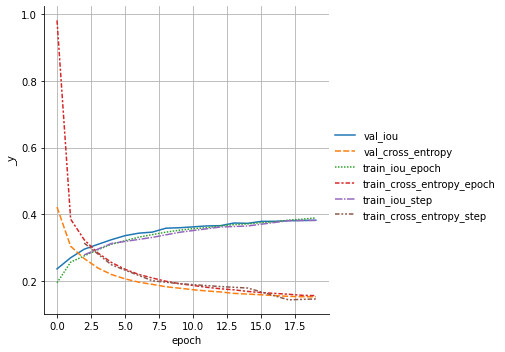

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.grid()

## 4. Segment a few images!

In [9]:
import os, glob

sample_imgs = glob.glob("../input/lyft-udacity-challenge/dataB/dataB/CameraRGB/*.png")[:10]

datamodule = SemanticSegmentationData.from_files(
    predict_files=sample_imgs,
    batch_size=3,
)

Predicting: 20it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


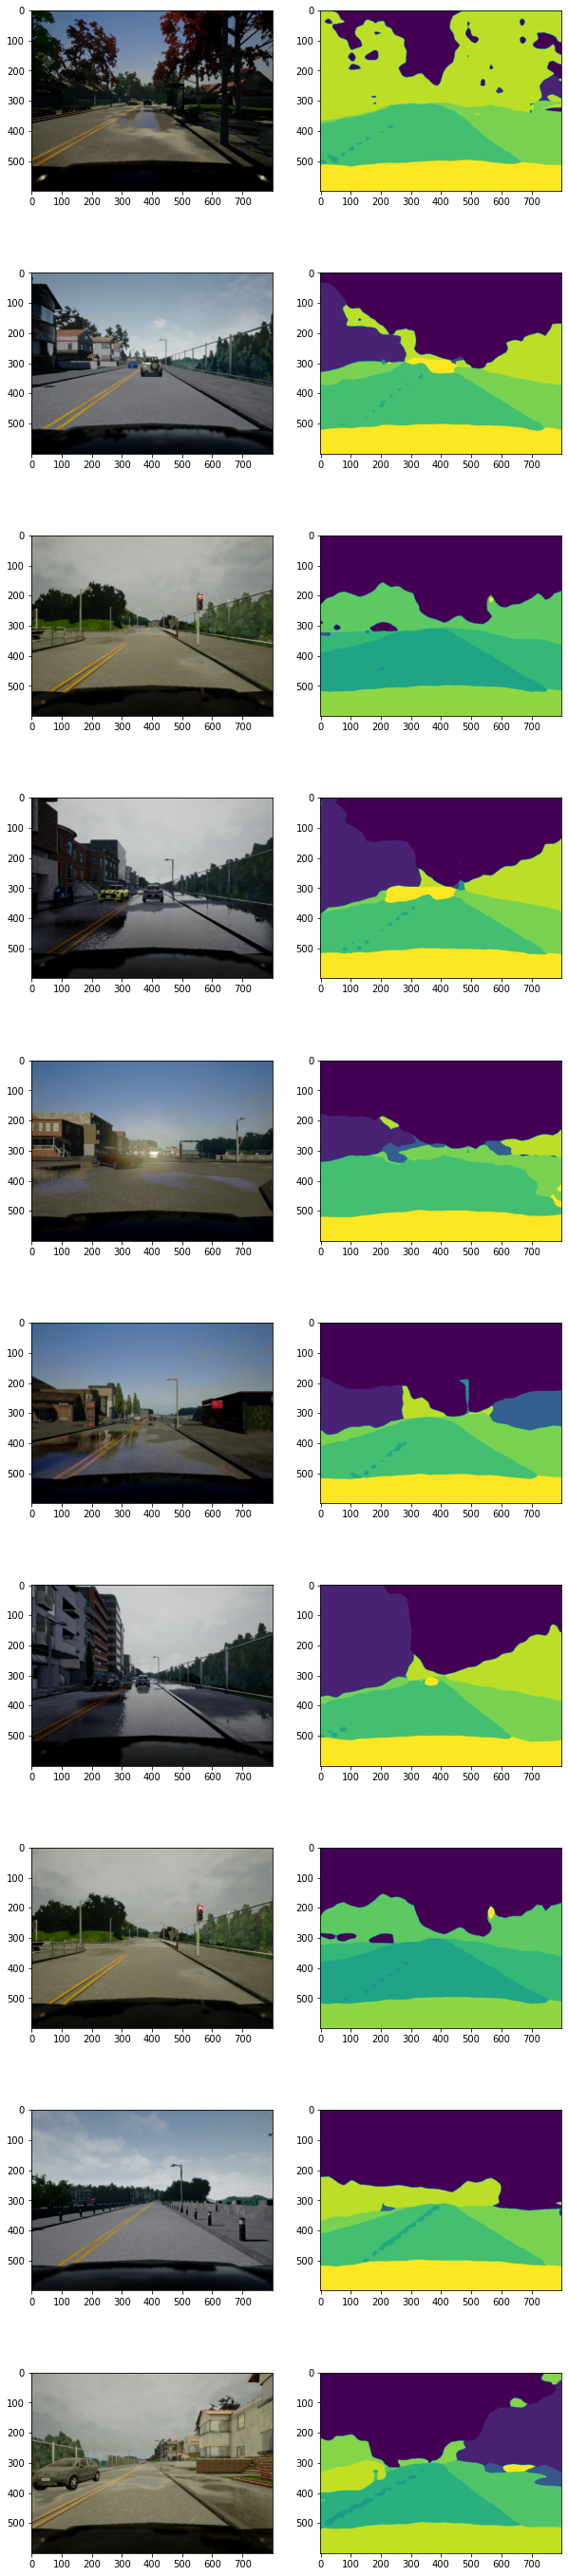

In [10]:
fig, axarr = plt.subplots(ncols=2, nrows=len(sample_imgs), figsize=(10, 5 * len(sample_imgs)))
running_i = 0
for preds in trainer.predict(model, datamodule=datamodule, output="labels"):
    for pred in preds:
        img = plt.imread(sample_imgs[running_i])
        axarr[running_i, 0].imshow(img)
        axarr[running_i, 1].imshow(pred)
        running_i += 1